In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_subject_levels

In [2]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')

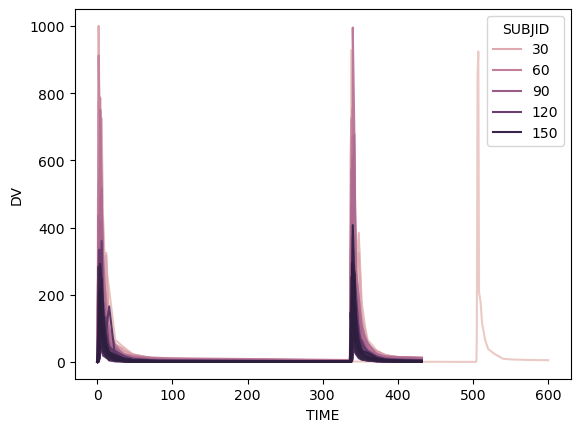

In [3]:
plot_subject_levels(df)

In [4]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
from utils import one_compartment_model, objective_function

In [5]:
#prepare day 1 data
opt_df = df.dropna(subset = 'DV').copy()
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

#Within day 1 data, per subject identify the max concentration
#Drop time points occuring before the max, and set the time at that max conc to t=0
dfs = []
for c in opt_df['SUBJID'].drop_duplicates():
    work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
    max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
    work_df = work_df.iloc[max_idx:, :]
    work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
    dfs.append(work_df.copy())
work_df = pd.concat(dfs)

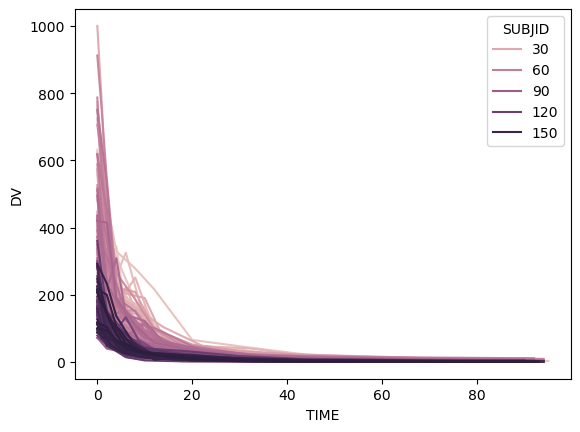

In [6]:
#plot the prepared data
plot_subject_levels(work_df)

In [7]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial
from utils import optimize_with_checkpoint_joblib

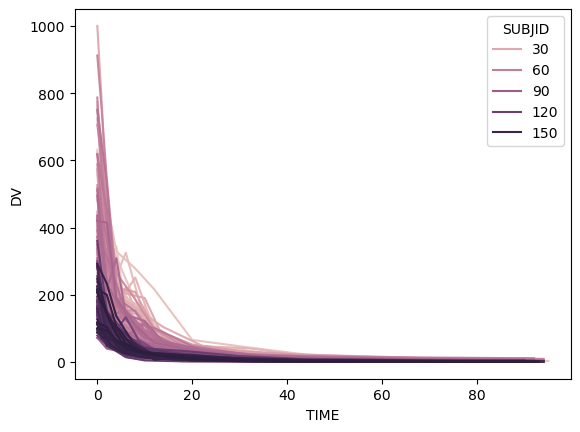

In [8]:
from sklearn.preprocessing import RobustScaler
scale_df = work_df.copy()
#scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
mgkg_scaler = RobustScaler()
age_scaler = RobustScaler()
wt_scaler = RobustScaler()

scale_df['MGKG'] = (scale_df['DOSR'] / scale_df['WT'])
scale_df['WT_scale'] = wt_scaler.fit_transform(scale_df[['WT']])
scale_df['MGKG_scale'] = mgkg_scaler.fit_transform(scale_df[['MGKG']])
scale_df['AGE_scale'] = age_scaler.fit_transform(scale_df[['AGE']])
scale_df['DOSR'] = scale_df['DOSR'] / 100
plot_subject_levels(scale_df)

In [9]:
scale_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,MGKG,WT_scale,MGKG_scale,AGE_scale
2,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
3,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
4,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
5,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
6,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,1.0,NaN,7.91,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
11,159.0,1.0,1.0,33.0,36.0,1.0,NaN,3.02,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
12,159.0,1.0,1.0,45.0,48.0,1.0,NaN,1.7,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
13,159.0,1.0,1.0,69.0,72.0,1.0,NaN,1.42,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429


In [10]:
from utils import OneCompartmentModel, ObjectiveFunctionColumn
mod_sse = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX' )],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                         model_method='linear',
                                                                         
                                                                         allometric_norm_value=wt_scaler.transform([[70]])[0][0], 
                                                                         
                                                                         )]}, 
                              #loss_function=sum_of_squares_loss, 
                              optimizer_tol=None
                              )

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [11]:
init_summary = mod_sse.init_vals_pd

In [12]:
import pymc as pm

In [13]:
model_params = init_summary.loc[init_summary['population_coeff'], :]
model_params

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value
0,k,None,True,-0.510826,False,NaN
1,vd,None,True,0.693147,False,NaN


In [14]:
model_param_dep_vars = init_summary.loc[init_summary['population_coeff'] == False, :]
model_param_dep_vars

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value
2,k,AGE_scale,False,0.0,False,NaN
3,k,SEX,False,0.0,False,NaN
4,vd,WT_scale,False,0.0,False,-0.5625


In [15]:
print(f"model_params = pd.DataFrame({model_params.to_dict()})")

model_params = pd.DataFrame({'model_coeff': {0: 'k', 1: 'vd'}, 'model_coeff_dep_var': {0: None, 1: None}, 'population_coeff': {0: True, 1: True}, 'init_val': {0: -0.5108256237659907, 1: 0.6931471805599453}, 'allometric': {0: False, 1: False}, 'allometric_norm_value': {0: nan, 1: nan}})


In [16]:
print(f"model_param_dep_vars = pd.DataFrame({model_param_dep_vars.to_dict()})")

model_param_dep_vars = pd.DataFrame({'model_coeff': {2: 'k', 3: 'k', 4: 'vd'}, 'model_coeff_dep_var': {2: 'AGE_scale', 3: 'SEX', 4: 'WT_scale'}, 'population_coeff': {2: False, 3: False, 4: False}, 'init_val': {2: 0.0, 3: 0.0, 4: 0.0}, 'allometric': {2: False, 3: False, 4: False}, 'allometric_norm_value': {2: nan, 3: nan, 4: -0.5625}})


In [17]:
model_param_dep_vars.to_dict()

{'model_coeff': {2: 'k', 3: 'k', 4: 'vd'},
 'model_coeff_dep_var': {2: 'AGE_scale', 3: 'SEX', 4: 'WT_scale'},
 'population_coeff': {2: False, 3: False, 4: False},
 'init_val': {2: 0.0, 3: 0.0, 4: 0.0},
 'allometric': {2: False, 3: False, 4: False},
 'allometric_norm_value': {2: nan, 3: nan, 4: -0.5625}}

In [18]:
def one_compartment_model(t, y, theta ):
    """
    Defines the differential equation for a one-compartment pharmacokinetic model.

    This function calculates the rate of change of drug concentration in the central 
    compartment over time.

    Args:
      t (float): Time point (not used in this specific model, but required by solve_ivp).
      y (list): Current drug concentration in the central compartment.
      k (float): Elimination rate constant.
      Vd (float): Volume of distribution.


    Returns:
      float: The rate of change of drug concentration (dC/dt).
    """
    k, Vd = theta
    C = y[0]  # Extract concentration from the state vector
    dCdt = -(k/Vd) * C  # Calculate the rate of change
    return dCdt

In [19]:
from pytensor.compile.ops import as_op
import pytensor.tensor as pt
import pytensor
from scipy.integrate import solve_ivp
import os

# Set PyTensor flags for debugging
os.environ["PYTENSOR_FLAGS"] = "optimizer=fast_compile,exception_verbosity=high"

In [ ]:
work_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
2,1.0,1.0,1.0,0.0,1.0,300.0,NaN,275.0,0.0,B,1.0,26.0,84.0
3,1.0,1.0,1.0,1.0,2.0,300.0,NaN,244.0,0.0,B,1.0,26.0,84.0
4,1.0,1.0,1.0,2.0,3.0,300.0,NaN,151.0,0.0,B,1.0,26.0,84.0
5,1.0,1.0,1.0,3.0,4.0,300.0,NaN,130.0,0.0,B,1.0,26.0,84.0
6,1.0,1.0,1.0,5.0,6.0,300.0,NaN,147.0,0.0,B,1.0,26.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,100.0,NaN,7.91,1.0,B,1.0,33.0,95.0
11,159.0,1.0,1.0,33.0,36.0,100.0,NaN,3.02,1.0,B,1.0,33.0,95.0
12,159.0,1.0,1.0,45.0,48.0,100.0,NaN,1.7,1.0,B,1.0,33.0,95.0
13,159.0,1.0,1.0,69.0,72.0,100.0,NaN,1.42,1.0,B,1.0,33.0,95.0


In [21]:
#needed_idx = scale_df['TIME'].value_counts()[:10].index.values
scale_df_filter = []
for sub in scale_df['SUBJID'].unique():
    work_df = scale_df.loc[scale_df['SUBJID'] == sub, :].copy()
    tp = work_df['TIME'].values[:10]
    work_df = work_df.loc[work_df['TIME'].isin(tp), :]
    #nrows = len(work_df)
    #if nrows == len(needed_idx):
    scale_df_filter.append(work_df.copy())
scale_df_filter = pd.concat(scale_df_filter)
    

In [22]:
debug_df = scale_df.loc[scale_df['SUBJID'].isin([1, 2]), :]
debug_df = debug_df.loc[(debug_df['TIME'] < 30) & (debug_df['TIME'] != 3), :]

In [23]:
debug_df = scale_df_filter.copy()

In [24]:
all_subject_data = debug_df[['SUBJID', 'AGE_scale', 'WT_scale', 'SEX', 'DV']].drop_duplicates(subset = 'SUBJID', keep='first').copy()

In [25]:
pm_df = debug_df.copy().reset_index(drop = True)
pm_subj_df = all_subject_data.copy().reset_index(drop = True)

In [26]:
tps = pm_df.groupby('SUBJID')['TIME'].unique().reset_index().rename(columns = {'TIME':'subj_tp'})
tps_min = pm_df.groupby('SUBJID')['TIME'].min().reset_index().rename(columns = {'TIME':'subj_tp_min'})
tps_max = pm_df.groupby('SUBJID')['TIME'].max().reset_index().rename(columns = {'TIME':'subj_tp_max'})

In [27]:
pm_subj_df = (pm_subj_df.merge(tps, how = 'left', on = 'SUBJID')
                    .merge(tps_min, how = 'left', on = 'SUBJID')
                    .merge(tps_max, how = 'left', on = 'SUBJID')
                    
                    )

In [28]:
pm_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,MGKG,WT_scale,MGKG_scale,AGE_scale
0,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
1,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
2,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
3,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
4,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,159.0,1.0,1.0,13.0,16.0,1.0,NaN,18.700001,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
1525,159.0,1.0,1.0,21.0,24.0,1.0,NaN,7.91,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
1526,159.0,1.0,1.0,33.0,36.0,1.0,NaN,3.02,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
1527,159.0,1.0,1.0,45.0,48.0,1.0,NaN,1.7,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429


In [29]:
pm_subj_df

,SUBJID,AGE_scale,WT_scale,SEX,DV,subj_tp,subj_tp_min,subj_tp_max
0,1.0,0.071429,0.3125,1.0,275.0,"[0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 11.0, 15.0, 23....",0.0,35.0
1,2.0,1.571429,-0.6875,0.0,625.0,"[0.0, 1.0, 2.0, 4.0, 6.0, 10.0, 14.0, 22.0, 34...",0.0,46.0
2,3.0,0.428571,0.0000,1.0,498.0,"[0.0, 1.0, 2.0, 4.0, 6.0, 10.0, 14.0, 22.0, 34...",0.0,46.0
3,4.0,-0.428571,-0.2500,1.0,302.0,"[0.0, 1.0, 2.0, 4.0, 6.0, 10.0, 14.0, 22.0, 34...",0.0,46.0
4,5.0,1.714286,0.5625,1.0,632.0,"[0.0, 1.0, 2.0, 4.0, 6.0, 10.0, 14.0, 22.0, 34...",0.0,46.0
...,...,...,...,...,...,...,...,...
154,155.0,-0.214286,-0.0625,1.0,247.0,"[0.0, 2.0, 6.0, 10.0, 18.0, 30.0, 42.0, 66.0, ...",0.0,90.0
155,156.0,0.000000,-0.2500,1.0,217.0,"[0.0, 2.0, 4.0, 8.0, 12.0, 20.0, 32.0, 44.0, 6...",0.0,92.0
156,157.0,-0.214286,0.5625,1.0,117.0,"[0.0, 2.0, 4.0, 8.0, 12.0, 20.0, 32.0, 44.0, 6...",0.0,92.0
157,158.0,0.071429,0.2500,1.0,101.0,"[0.0, 2.0, 6.0, 10.0, 18.0, 30.0, 42.0, 66.0, ...",0.0,90.0


In [30]:
import logging

# Configure logging to capture console output
logging.basicConfig(filename='pymc_debug.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [31]:
coords = {'subject':list(pm_subj_df['SUBJID'].values), 
          'obs_id': list(pm_df.index.values)
          }

In [32]:
import functools

old_subj_loop = True
pt_printing = True
with pm.Model(coords=coords) as model:
    
    data_obs = pm.Data('dv', pm_df['DV'].values, dims = 'obs_id')
    #subject_init_conc = pm.Data('c0', pm_subj_df['DV'].values, dims = 'subject')
    #subject_tps = pm.MutableData('subject_tp', pm_subj_df['subj_tp'].values, dims = 'subject')
    #sub_tps = {}
    #for sub in coords['subject']:
    #    one_subject_tps = np.array(pm_subj_df.loc[pm_subj_df['SUBJID'] == 1.0, 'subj_tp'].values[0])
    #    sub_tps[sub] = pm.Data(f"subject{sub}_timepoints", one_subject_tps)
    #subject_max_tp = pm.Data('subject_tp_max', pm_subj_df['subj_tp_max'].values, dims = 'subject')
    #subject_min_tp = pm.Data('subject_tp_min', pm_subj_df['subj_tp_min'].values, dims = 'subject')

    subject_data = {}
    betas = {}
    seen_coeff = []
    for idx, row in model_param_dep_vars.iterrows():
        coeff_name = row['model_coeff']
        
        beta_name = row['model_coeff_dep_var']
        if coeff_name not in seen_coeff:
            betas[coeff_name] = {}
            subject_data[coeff_name] = {}
        betas[coeff_name].update({beta_name:pm.Normal(f"beta_{coeff_name}_{beta_name}", mu = 0, sigma = 1)})
        subject_data[coeff_name].update(
            {beta_name:pm.Data(f"data_{coeff_name}_{beta_name}", pm_subj_df[beta_name].values,
                                      dims = 'subject'
                                      )
             }
            )
        seen_coeff.append(coeff_name)
        
    population_coeff = {}
    pop_coeff_intercept_mu = {}
    pop_coeff_intercept_sigma = {}
    pop_coeff_intercept_i = {}
    pm_model_params = []
    for idx, row in model_params.iterrows():
        coeff_name = row['model_coeff']
        pop_coeff_init = 0
        while pop_coeff_init == 0:
            pop_coeff_init = np.random.rand()
            
        #ensure that neither init value is zero, I think that can make the graphviz fail
        population_coeff[coeff_name]=pm.Normal(f"{coeff_name}_pop", mu = 0, sigma = 1, initval=pop_coeff_init)
        
        pop_coeff_intercept_mu[coeff_name] = pm.Normal(f"{coeff_name}_intercept_mu", mu = 0, sigma = 1)
        pop_coeff_intercept_sigma[coeff_name] = pm.HalfNormal(f"{coeff_name}_intercept_sigma", sigma = 10)
        pop_coeff_intercept_i[coeff_name] = pm.Normal(f"{coeff_name}_intercept_sub",
                                                      mu = pop_coeff_intercept_mu[coeff_name], 
                                                      sigma = pop_coeff_intercept_sigma[coeff_name],
                                                      dims = 'subject'
                                                      )
        print(f"Shape of pop_coeff_intercept_i[{coeff_name}]: {pop_coeff_intercept_i[coeff_name].shape.eval()}")
        model_coeff = (population_coeff[coeff_name] + pop_coeff_intercept_i[coeff_name])
        for beta_name in betas[coeff_name]:
            print(f"Shape of model_coeff: {model_coeff.shape.eval()}")
            print(f"Shape of betas[{coeff_name}][{beta_name}]: {betas[coeff_name][beta_name].shape.eval()}")
            print(f"Shape of pm_subj_df[{beta_name}]: {subject_data[coeff_name][beta_name].shape.eval()}")
            #print(f"Shape of pm_subj_df[{beta_name}][{sub_idx}]: {pm_subj_df[beta_name][sub_idx].shape}")
            model_coeff = pm.math.exp((model_coeff + betas[coeff_name][beta_name] * subject_data[coeff_name][beta_name]))
        pm_model_params.append(
            pm.Deterministic(f"{coeff_name}_i", model_coeff, dims = 'subject')
        )
    all_conc = [] 
    print(coords['subject'])
    for sub_idx, subject_id in enumerate(coords['subject']):
        print(subject_id)
        subject_data = pm_df.loc[pm_df['SUBJID'] == subject_id, :]
        print(subject_data.shape)
        #initial_conc = subject_init_conc[sub_idx]
        initial_conc = subject_data['DV'].values[0]#.item()
        t_eval = subject_data['TIME'].values
        #t_eval = sub_tps[subject]
        #t_span = [subject_min_tp[sub_idx], subject_max_tp[sub_idx]]
        t_span = [np.min(subject_data['TIME'].values), np.max(subject_data['TIME'].values)]
        theta = [i[sub_idx] for i in pm_model_params]
        if old_subj_loop:
            
            def create_forward_model(subject_id_val, t_span, t_eval, initial_conc):
                @as_op(itypes=[pt.dscalar for i in pm_model_params], otypes=[pt.dvector])
                #@functools.wraps(pytensor_forward_model_matrix)
                def pytensor_forward_model_matrix(*args):
                    #print(subject_id_val)
                    theta = [i for i in args]
                    sol = solve_ivp(one_compartment_model, t_span, [initial_conc], t_eval=t_eval, args=(theta,) )
                    #print("sol.status:", sol.status)  # Print the status code
                    #print("sol.message:", sol.message) # Print the status message
                    ode_sol = sol.y[0]
                    #print("\nShape of ode_sol within function:", ode_sol.shape)
                    #print("\nValues of ode_sol within function:", ode_sol)
                    return ode_sol
                return pytensor_forward_model_matrix
        pytensor_forward_model_matrix = create_forward_model(subject_id, t_span, t_eval, initial_conc, )
        
        #theta = pytensor.printing.Print("\nShape of theta before stack")(pt.shape(theta))
        #theta = pm.math.stack(theta)
        #theta = pytensor.printing.Print("\nShape of theta after stack")(pt.shape(theta))
        #print
        if old_subj_loop:
            ode_sol = pytensor_forward_model_matrix(*theta) #issue could be that this is not the same length for each subject
        else:
            sol = solve_ivp(one_compartment_model, t_span, [initial_conc], t_eval=t_eval, args=(*theta,) )
            #print(sol)
            ode_sol = sol#.y[0] 
        #if pt_printing:
            #_ = pytensor.printing.Print("Shape of ode_sol")(pt.shape(ode_sol))
            #ode_sol = pytensor.printing.Print("ode_sol Values:")(ode_sol)
        all_conc.append(ode_sol)
    all_conc = pt.concatenate(all_conc, axis=0)
    all_conc_pm = pm.Deterministic('all_conc', all_conc)
    #if pt_printing:
    #    all_conc = pytensor.printing.Print("Shape of all_conc")(
    #    pt.shape(all_conc)
    #)
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=1)
    pm.LogNormal("obs", mu=all_conc_pm, sigma=sigma_obs, observed=data_obs)
        
        

Shape of pop_coeff_intercept_i[k]: [159]
Shape of model_coeff: [159]
Shape of betas[k][AGE_scale]: []
Shape of pm_subj_df[AGE_scale]: [159]
Shape of model_coeff: [159]
Shape of betas[k][SEX]: []
Shape of pm_subj_df[SEX]: [159]
Shape of pop_coeff_intercept_i[vd]: [159]
Shape of model_coeff: [159]
Shape of betas[vd][WT_scale]: []
Shape of pm_subj_df[WT_scale]: [159]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0

In [33]:
k_init = 0
while k_init == 0:
    print(k_init)
    k_init = np.random.rand()
    print(k_init)

0
0.9408134303552114


In [34]:
pm.model_to_graphviz(model)

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:735: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


KeyboardInterrupt: 

In [35]:
vars_list = list(model.values_to_rvs.keys())[:-1]

sampler = "DEMetropolisZ"
tune = draws = 2000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains = 4, cores = 4)


Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [beta_k_AGE_scale, beta_k_SEX, beta_vd_WT_scale, k_pop, k_intercept_mu, k_intercept_sigma, k_intercept_sub, vd_pop, vd_intercept_mu, vd_intercept_sigma, vd_intercept_sub, sigma_obs]


Output()

: 

: 

In [32]:
trace_DEMZ

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [29]:
with model:
    res = pm.sample_posterior_predictive(trace_DEMZ)

Sampling: [obs]


Output()

ValueError: Output size (25, 1) is not compatible with broadcast dimensions of inputs (25, 24).
Apply node that caused the error: lognormal_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x7F56094B7060>), [25  1], ExpandDims{axis=0}.0, ExpandDims{axes=[0, 1]}.0)
Toposort index: 9
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(float64, shape=(1, None)), TensorType(float64, shape=(1, 1))]
Inputs shapes: ['No shapes', (2,), (1, 24), (1, 1)]
Inputs strides: ['No strides', (8,), (192, 8), (8, 8)]
Inputs values: [Generator(PCG64) at 0x7F56094B7060, array([25,  1]), 'not shown', array([[1.001827]])]
Outputs clients: [[output[1](lognormal_rv{"(),()->()"}.0)], [output[0](obs)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2662/3741561388.py", line 81, in <module>
    pm.LogNormal("obs", mu=all_conc, sigma=sigma_obs, observed=pm_df["DV"].values.reshape(-1,1))
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 511, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/continuous.py", line 1715, in dist
    return super().dist([mu, sigma], *args, **kwargs)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 580, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.